In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models, optimizers
from keras.callbacks import EarlyStopping
from keras.applications import EfficientNetB4
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "dataset"
IMG_SIZE = (512, 512)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 123
EPOCHS = 20
PATIENCE = 3
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="training",
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="binary",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset="validation",
)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

Found 370 files belonging to 2 classes.
Using 296 files for training.
Found 370 files belonging to 2 classes.
Using 74 files for validation.


In [4]:
base = EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(*IMG_SIZE, 3),
)
base.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = models.Model(inputs, outputs, name="oak_wilt_effb4")

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "oak_wilt_effb4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 16, 16, 1792)   │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,793 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,675,616 (67.43 MB)

 Trainable params: 1,793 (7.00 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [5]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=PATIENCE,
    restore_best_weights=True,
)
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.5344 - loss: 0.7133 - val_accuracy: 0.5811 - val_loss: 0.6834
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.5606 - loss: 0.6968 - val_accuracy: 0.6757 - val_loss: 0.6583
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5490 - loss: 0.6850 - val_accuracy: 0.8108 - val_loss: 0.6356
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 36s 4s/step - accuracy: 0.6336 - loss: 0.6467 - val_accuracy: 0.8108 - val_loss: 0.6143
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.6372 - loss: 0.6326 - val_accuracy: 0.8514 - val_loss: 0.5928


In [6]:
base.trainable = True
for layer in base.layers[:-50]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stop],
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 51s 5s/step - accuracy: 0.6933 - loss: 0.6319 - val_accuracy: 0.8514 - val_loss: 0.5775
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.7161 - loss: 0.6225 - val_accuracy: 0.8919 - val_loss: 0.5622
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.7430 - loss: 0.5906 - val_accuracy: 0.8919 - val_loss: 0.5457
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.8081 - loss: 0.5507 - val_accuracy: 0.8919 - val_loss: 0.5287
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.8417 - loss: 0.5172 - val_accuracy: 0.8919 - val_loss: 0.5122
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8515 - loss: 0.5073 - val_accuracy: 0.8919 - val_loss: 0.4960
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.8691 - loss: 0.4845 - val_accuracy: 0.8919 - val_loss: 0.4803
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.8930 - loss: 0.4548 - val_accuracy: 0.9054 - val_loss:

In [7]:
out_path = "oak_wilt_effb4-old.keras"
model.save(out_path)
print(f"\nModel saved to: {out_path}")


Model saved to: oak_wilt_effb4.keras


# Analysis

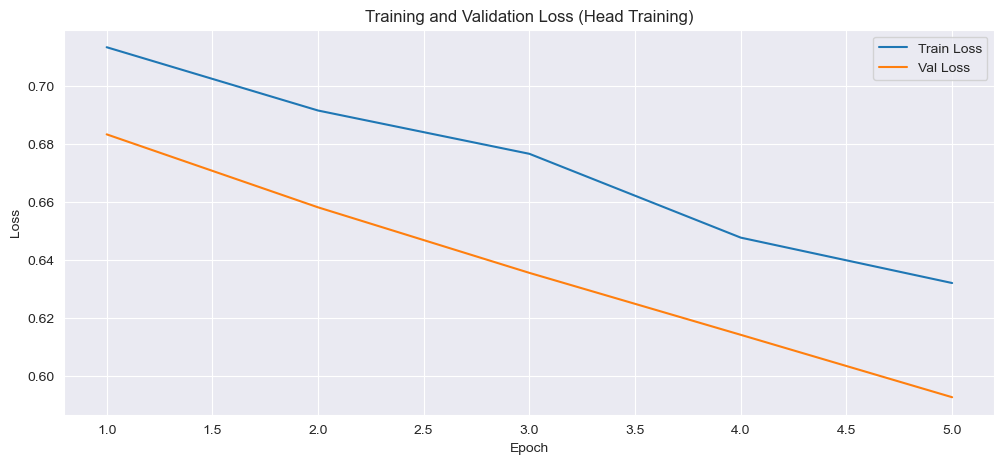

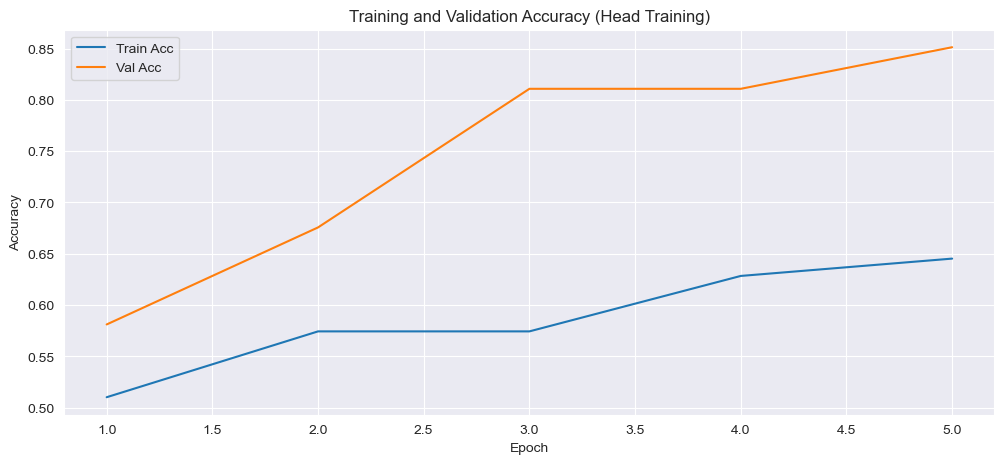

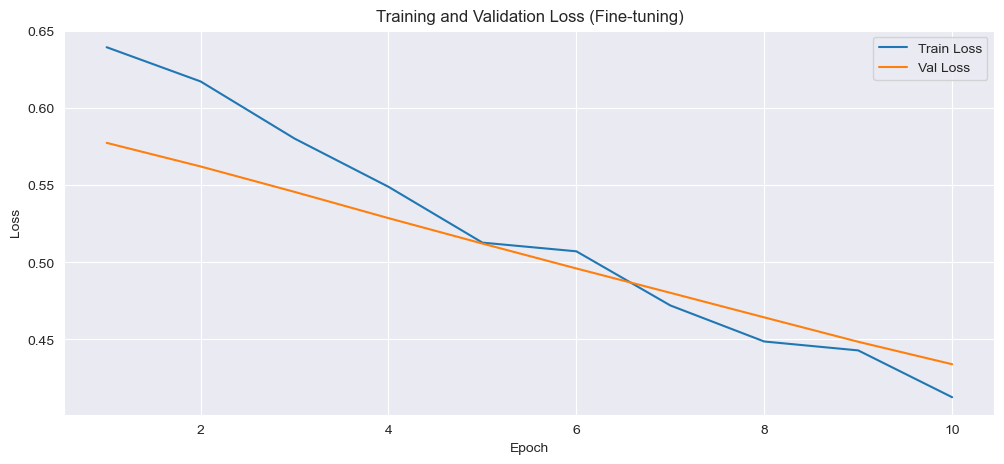

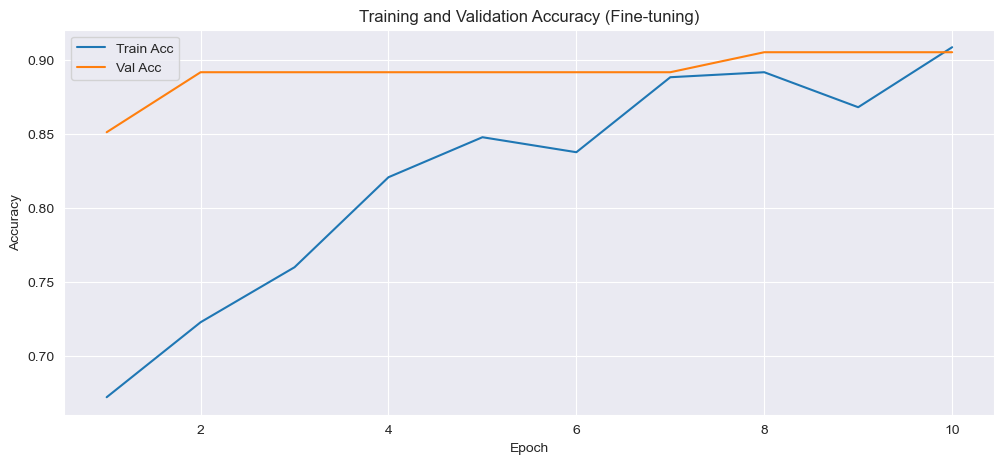

2025-07-15 22:48:07.091161: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step

Classification Report:
               precision    recall  f1-score   support

     healthy       0.51      0.53      0.52        36
   unhealthy       0.54      0.53      0.53        38

    accuracy                           0.53        74
   macro avg       0.53      0.53      0.53        74
weighted avg       0.53      0.53      0.53        74


Confusion Matrix:
 [[19 17]
 [18 20]]


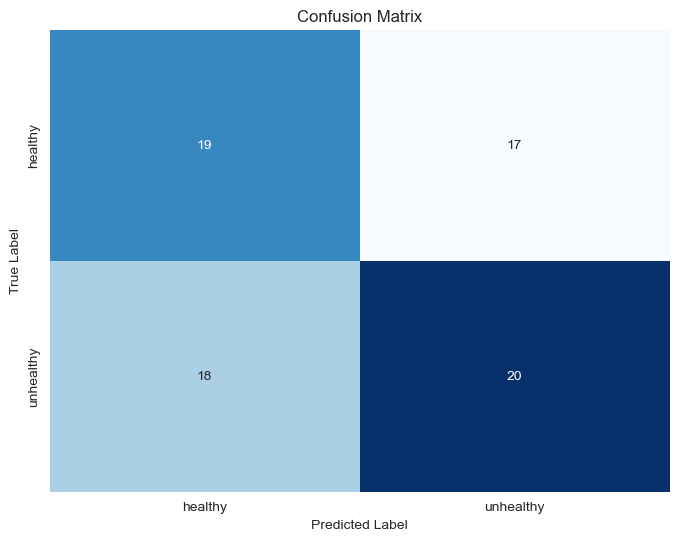

In [8]:
def plot_history(history, title_suffix=""):
    df_hist = pd.DataFrame(history.history)
    df_hist['epoch'] = df_hist.index + 1

    plt.figure(figsize=(12,5))
    sns.lineplot(x='epoch', y='loss', data=df_hist, label='Train Loss')
    sns.lineplot(x='epoch', y='val_loss', data=df_hist, label='Val Loss')
    plt.title(f'Training and Validation Loss{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12,5))
    sns.lineplot(x='epoch', y='accuracy', data=df_hist, label='Train Acc')
    sns.lineplot(x='epoch', y='val_accuracy', data=df_hist, label='Val Acc')
    plt.title(f'Training and Validation Accuracy{title_suffix}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot histories
plot_history(history, " (Head Training)")
plot_history(history_fine, " (Fine-tuning)")

# Evaluate on validation set
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0).flatten()
y_pred_proba = model.predict(val_ds).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Classification report
cr = classification_report(y_true, y_pred, target_names=["healthy", "unhealthy"])
print("\nClassification Report:\n", cr)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:\n", cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=["healthy","unhealthy"], yticklabels=["healthy","unhealthy"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()